In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 1. DATA LOADING AND INITIAL EXPLORATION

In [2]:
# Load dataset
df = pd.read_csv('ci_cd_logs.csv')

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData Types:")
print(df.dtypes)
print(f"\nBasic Statistics:")
print(df.describe())

DATASET OVERVIEW
Shape: (800, 11)
Columns: ['timestamp', 'pipeline_id', 'stage_name', 'job_name', 'task_name', 'status', 'message', 'commit_id', 'branch', 'user', 'environment']

First 5 rows:
                  timestamp pipeline_id stage_name           job_name  \
0  2024-03-02 01:05:07+0000  pipe-txnem      Build  deploy_to_staging   
1  2024-07-22 19:55:41+0000  pipe-hjahz      Build     run_unit_tests   
2  2024-03-01 23:03:43+0000  pipe-vcsbx   Analysis      deploy_to_dev   
3  2024-06-02 12:21:00+0000  pipe-pnvzk       Test      deploy_to_dev   
4  2024-04-17 07:59:29+0000  pipe-mwkkl       Test     build_and_test   

  task_name   status                                       message  \
0   analyze  success                  Task completed successfully.   
1    deploy  skipped  Task was skipped due to pipeline conditions.   
2    deploy  success                  Task completed successfully.   
3      test  skipped  Task was skipped due to pipeline conditions.   
4      test   fail

# 2. DATA QUALITY ASSESSMENT


DATA QUALITY CHECK

Missing Values:
                  Column  Missing_Count  Percentage
user                user            397       49.62
environment  environment            619       77.38

Duplicate Rows: 0

Status Distribution:
status
skipped    219
running    206
failed     194
success    181
Name: count, dtype: int64

Failure Rate: 24.25%


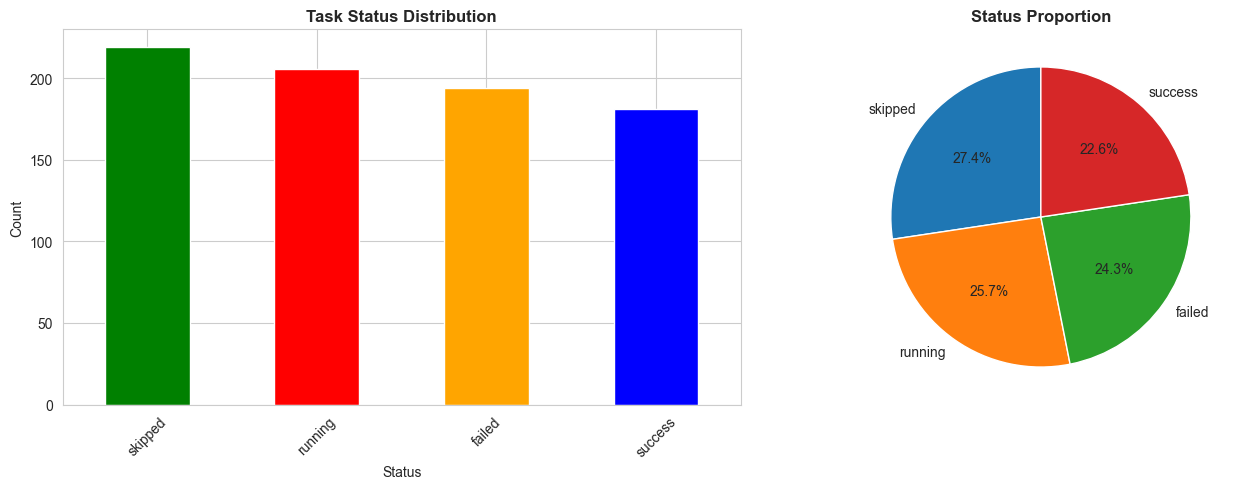

In [3]:
print("\n" + "="*70)
print("DATA QUALITY CHECK")
print("="*70)

# Missing values
print("\nMissing Values:")
missing = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing[missing['Missing_Count'] > 0])

# Duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates}")

# Status distribution
print("\nStatus Distribution:")
print(df['status'].value_counts())
print(f"\nFailure Rate: {(df['status'] == 'failed').sum() / len(df) * 100:.2f}%")

# Visualize status distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df['status'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red', 'orange', 'blue'])
axes[0].set_title('Task Status Distribution', fontweight='bold')
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

axes[1].pie(df['status'].value_counts().values, labels=df['status'].value_counts().index, 
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('Status Proportion', fontweight='bold')
plt.tight_layout()
plt.show()

# 3. DATA CLEANING

In [4]:
print("\n" + "="*70)
print("DATA CLEANING")
print("="*70)

df_clean = df.copy()

# Handle missing values
print("\n1. Handling Missing Values...")
df_clean['user'] = df_clean['user'].fillna('automated')
df_clean['environment'] = df_clean['environment'].fillna('not_specified')
print(f"   ✓ Filled {df['user'].isnull().sum()} missing 'user' values with 'automated'")
print(f"   ✓ Filled {df['environment'].isnull().sum()} missing 'environment' values")

# Remove duplicates
print("\n2. Removing Duplicates...")
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
print(f"   ✓ Removed {before - len(df_clean)} duplicate rows")

# Convert timestamp
print("\n3. Converting Timestamp...")
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
print("   ✓ Converted timestamp to datetime")

print(f"\n✓ Cleaned Dataset Shape: {df_clean.shape}")


DATA CLEANING

1. Handling Missing Values...
   ✓ Filled 397 missing 'user' values with 'automated'
   ✓ Filled 619 missing 'environment' values

2. Removing Duplicates...
   ✓ Removed 0 duplicate rows

3. Converting Timestamp...
   ✓ Converted timestamp to datetime

✓ Cleaned Dataset Shape: (800, 11)


# 4. FEATURE ENGINEERING

In [5]:
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

# Temporal features
print("\n1. Creating Temporal Features...")
df_clean['hour'] = df_clean['timestamp'].dt.hour
df_clean['day_of_week'] = df_clean['timestamp'].dt.dayofweek
df_clean['month'] = df_clean['timestamp'].dt.month
print("   ✓ Extracted: hour, day_of_week, month")

# Target variable
print("\n2. Creating Target Variable...")
df_clean['is_failure'] = (df_clean['status'] == 'failed').astype(int)
print(f"   ✓ Created binary target 'is_failure'")
print(f"   - Failures: {df_clean['is_failure'].sum()} ({df_clean['is_failure'].mean()*100:.2f}%)")

# Encode categorical variables
print("\n3. Encoding Categorical Features...")
le_stage = LabelEncoder()
le_job = LabelEncoder()
le_task = LabelEncoder()
le_env = LabelEncoder()

df_clean['stage_encoded'] = le_stage.fit_transform(df_clean['stage_name'])
df_clean['job_encoded'] = le_job.fit_transform(df_clean['job_name'])
df_clean['task_encoded'] = le_task.fit_transform(df_clean['task_name'])
df_clean['environment_encoded'] = le_env.fit_transform(df_clean['environment'])
print("   ✓ Encoded: stage_name, job_name, task_name, environment")

print(f"\n✓ Total Features: {df_clean.shape[1]}")


FEATURE ENGINEERING

1. Creating Temporal Features...
   ✓ Extracted: hour, day_of_week, month

2. Creating Target Variable...
   ✓ Created binary target 'is_failure'
   - Failures: 194 (24.25%)

3. Encoding Categorical Features...
   ✓ Encoded: stage_name, job_name, task_name, environment

✓ Total Features: 19


# 5. FAILURE PATTERN ANALYSIS


FAILURE PATTERN ANALYSIS

1. Failures by Stage:
stage_name
Test        51
Build       51
Deploy      48
Analysis    44
Name: count, dtype: int64

2. Failures by Job (Top 5):
job_name
run_unit_tests           46
run_integration_tests    42
deploy_to_dev            42
build_and_test           37
deploy_to_staging        27
Name: count, dtype: int64

3. Failures by Environment:
environment
not_specified    146
development       17
production        16
staging           15
Name: count, dtype: int64

4. Failures by Hour:
hour
0     14
20    13
7     12
1     12
8     11
dtype: int64


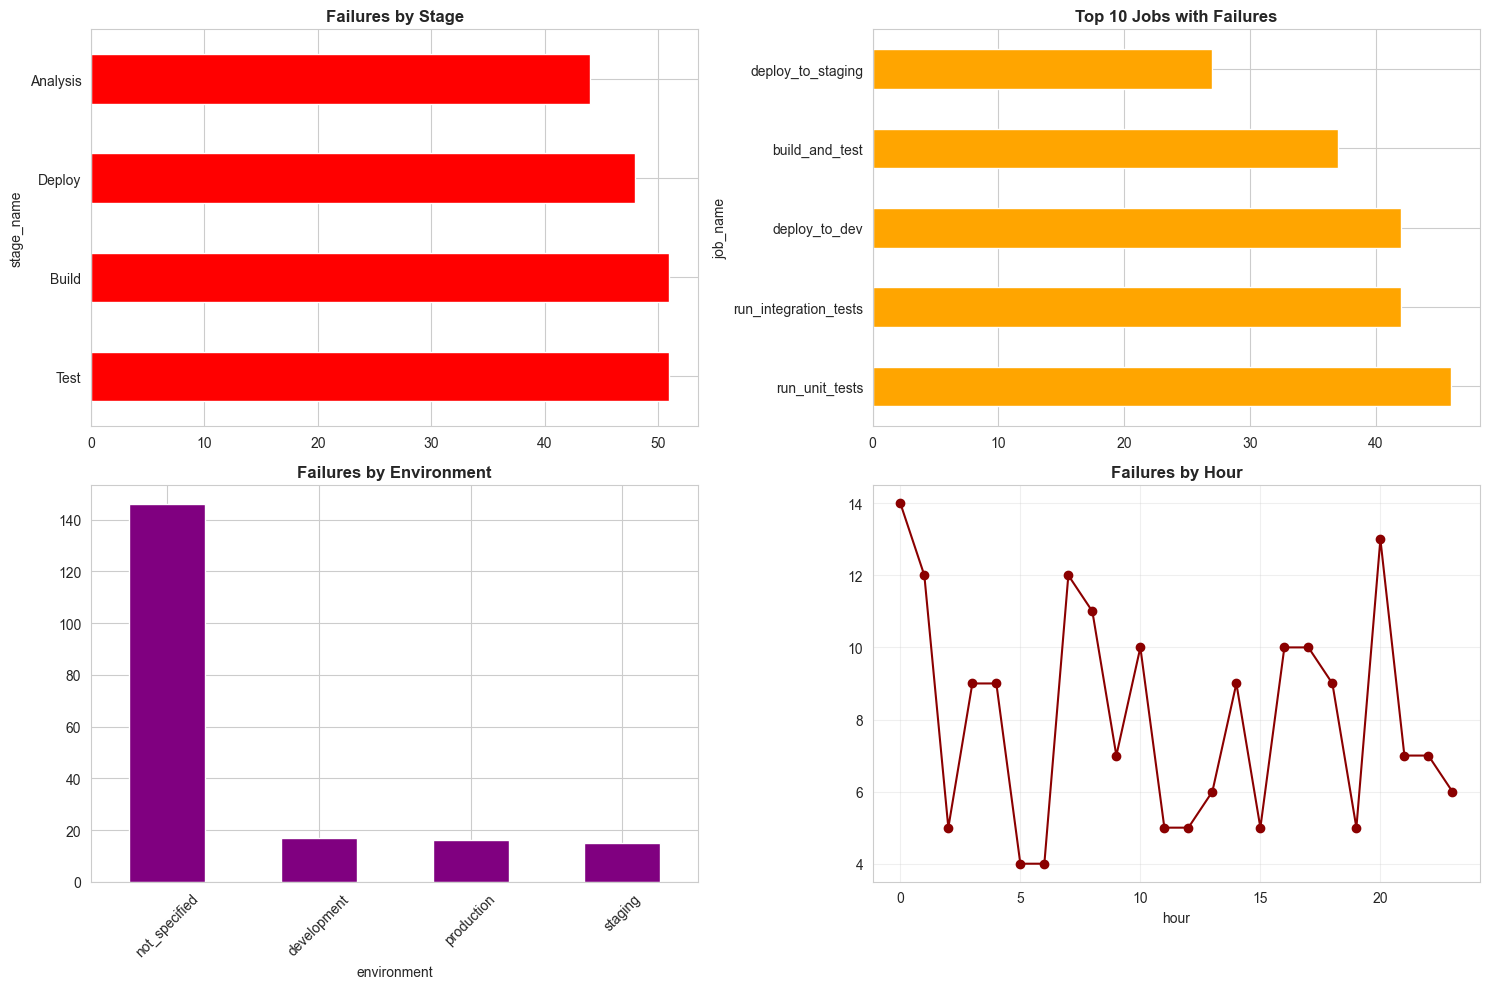

In [6]:
print("\n" + "="*70)
print("FAILURE PATTERN ANALYSIS")
print("="*70)

failures = df_clean[df_clean['status'] == 'failed']

print("\n1. Failures by Stage:")
print(failures['stage_name'].value_counts())

print("\n2. Failures by Job (Top 5):")
print(failures['job_name'].value_counts().head())

print("\n3. Failures by Environment:")
print(failures['environment'].value_counts())

print("\n4. Failures by Hour:")
print(failures.groupby('hour').size().sort_values(ascending=False).head())

# Visualize failure patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

failures['stage_name'].value_counts().plot(kind='barh', ax=axes[0,0], color='red')
axes[0,0].set_title('Failures by Stage', fontweight='bold')

failures['job_name'].value_counts().head(10).plot(kind='barh', ax=axes[0,1], color='orange')
axes[0,1].set_title('Top 10 Jobs with Failures', fontweight='bold')

failures['environment'].value_counts().plot(kind='bar', ax=axes[1,0], color='purple')
axes[1,0].set_title('Failures by Environment', fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=45)

failures.groupby('hour').size().plot(kind='line', ax=axes[1,1], marker='o', color='darkred')
axes[1,1].set_title('Failures by Hour', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. FEATURE SCALING

In [7]:
print("\n" + "="*70)
print("FEATURE SCALING")
print("="*70)

# Select numerical features
numerical_features = ['hour', 'day_of_week', 'month', 
                      'stage_encoded', 'job_encoded', 'task_encoded', 
                      'environment_encoded']

# Scale features
scaler = StandardScaler()
df_clean[numerical_features] = scaler.fit_transform(df_clean[numerical_features])
print("\n✓ Scaled features using StandardScaler")
print(f"  Features scaled: {len(numerical_features)}")


FEATURE SCALING

✓ Scaled features using StandardScaler
  Features scaled: 7


# 7. CORRELATION ANALYSIS


CORRELATION ANALYSIS

Correlation with Target (is_failure):
is_failure             1.000000
stage_encoded          0.036374
job_encoded            0.019044
day_of_week            0.000007
task_encoded          -0.007569
environment_encoded   -0.027567
month                 -0.031492
hour                  -0.057591
Name: is_failure, dtype: float64


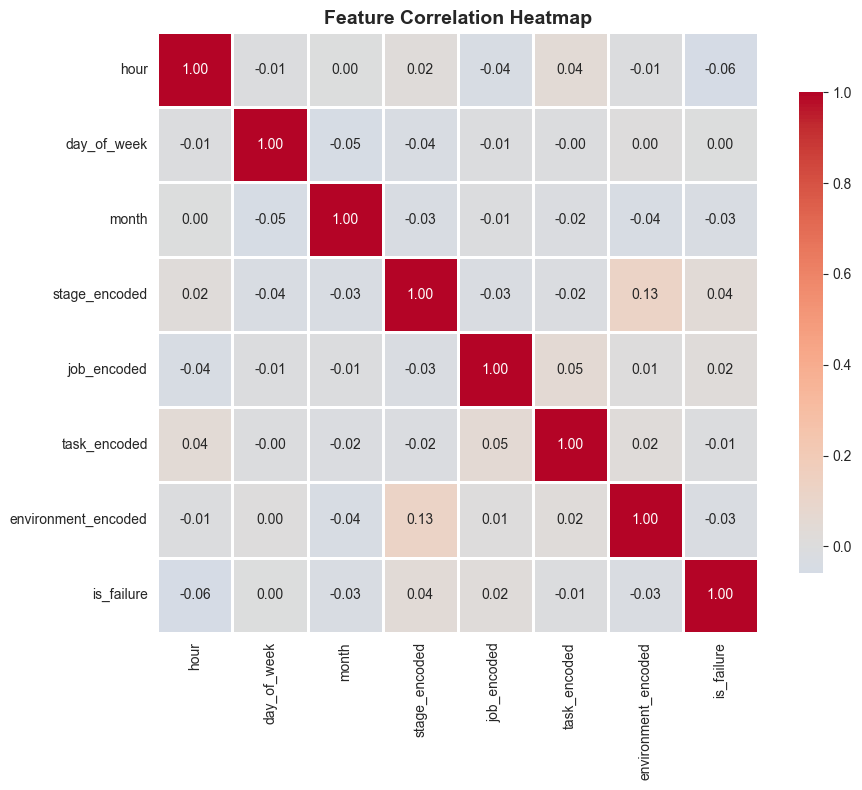

In [8]:
print("\n" + "="*70)
print("CORRELATION ANALYSIS")
print("="*70)

correlation_features = numerical_features + ['is_failure']
correlation_matrix = df_clean[correlation_features].corr()

print("\nCorrelation with Target (is_failure):")
target_corr = correlation_matrix['is_failure'].sort_values(ascending=False)
print(target_corr)

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 8. FINAL SUMMARY AND SAVE

In [9]:
print("\n" + "="*70)
print("FINAL DATASET SUMMARY")
print("="*70)

print(f"\nOriginal Shape: {df.shape}")
print(f"Cleaned Shape: {df_clean.shape}")
print(f"Records Removed: {len(df) - len(df_clean)}")

print(f"\nDate Range: {df_clean['timestamp'].min()} to {df_clean['timestamp'].max()}")
print(f"Total Pipelines: {df_clean['pipeline_id'].nunique()}")
print(f"Total Branches: {df_clean['branch'].nunique()}")
print(f"Total Users: {df_clean['user'].nunique()}")

print("\nTarget Distribution:")
print(df_clean['is_failure'].value_counts())
print(f"Failure Rate: {df_clean['is_failure'].mean()*100:.2f}%")

# Save cleaned dataset
output_file = 'ci_cd_logs_cleaned.csv'
df_clean.to_csv(output_file, index=False)
print(f"\n✓ Dataset saved as '{output_file}'")
print("\n" + "="*70)
print("DATA PREPROCESSING COMPLETE")
print("="*70)


FINAL DATASET SUMMARY

Original Shape: (800, 11)
Cleaned Shape: (800, 19)
Records Removed: 0

Date Range: 2024-01-01 09:04:56+00:00 to 2024-12-31 01:48:33+00:00
Total Pipelines: 800
Total Branches: 778
Total Users: 399

Target Distribution:
is_failure
0    606
1    194
Name: count, dtype: int64
Failure Rate: 24.25%

✓ Dataset saved as 'ci_cd_logs_cleaned.csv'

DATA PREPROCESSING COMPLETE
